In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from pandas.plotting import scatter_matrix
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
plt.style.use('bmh')
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import math

In [2]:
'''
Residential Water Consumption
'''
# Read in residential water consumption data file
residential = pd.read_csv('/Users/nowellk/projects/water-austin/data/Austin_Water_-_Residential_Water_Consumption.csv')

# Rename columns without spaces
residential.rename(columns={'Year Month': 'year_month', 'Postal Code': 'postal_code', 'Customer Class': 'customer_class', 'Total Gallons': 'total_gallons'}, inplace=True)

# Remove bad data rows
residential = residential[residential['year_month'] != 204406] #remove outlier
residential = residential[residential['year_month'] != 201710] #remove partial consumption data for Oct 2017

# Recognize Year Month number as date
residential['year_month'] = pd.to_datetime(residential['year_month'], format = '%Y%m')

# Extract date parts
residential['year'] = residential.year_month.dt.year.astype(int)
residential['month'] = residential.year_month.dt.month.astype(int)

# Remove unused column
residential = residential.drop(['year_month'], axis=1)

In [3]:
'''
Commercial Water Consumption
'''
# Read in commercial water consumption data file
commercial = pd.read_csv('/Users/nowellk/projects/water-austin/data/Austin_Water_-_Commercial_Water_Consumption.csv')

# Rename columns without spaces
commercial.rename(columns={'Year Month': 'year_month', 'Postal Code': 'postal_code', 'Customer Class': 'customer_class', 'Total Gallons': 'total_gallons'}, inplace=True)

# Recognize Year Month number as date
commercial['year_month'] = pd.to_datetime(commercial['year_month'], format = '%Y%m')

# Extract date parts
commercial['month'] = pd.to_datetime(commercial['year_month'], format = '%Y%m').dt.month
commercial['year'] = pd.to_datetime(commercial['year_month'], format = '%Y%m').dt.year

# Remove unused column
commercial = commercial.drop(['year_month'], axis=1)

In [4]:
'''
Issued Construction Permits
'''
# Read in Issued Construction Permits data file
permits = pd.read_csv('/Users/nowellk/projects/water-austin/data/Issued_Construction_Permits.csv')

# Filter for Finalized & Completed Residential Building Permitsonly
permits = permits[permits['PermitType'] == 'BP']
permits = permits[permits['PermitClassMapped'] == 'Residential']
permits = permits[permits['StatusCurrent'] == 'Final']
permits = permits[permits['CompletedDate'].isnull() == False]

# Remove Commas in Numerical Strings and Cast as Integer
permits['TotalJobValuation'] = permits.TotalJobValuation.str.replace(r'[^\d\.]','').astype(float).fillna(0.0).astype(int)
permits['TotalNewAddSQFT'] = permits.TotalNewAddSQFT.str.replace(r'[^\d\.]','').astype(float).fillna(0.0).astype(int)
permits['NumberOfFloors'] = permits.NumberOfFloors.str.replace(r'[^\d\.]','').fillna(0.0).astype(int)
permits['HousingUnits'] = permits.HousingUnits.str.replace(r'[^\d\.]','').fillna(0.0).astype(int)

# Cast Postal Code as Integer
permits['OriginalZip'] = permits.OriginalZip.fillna(0.0).astype(int)

# Recognize Date Formats
permits['AppliedDate'] =  pd.to_datetime(permits['AppliedDate'], format = '%Y/%m/%d')
permits['IssuedDate'] = pd.to_datetime(permits['IssuedDate'], format = '%Y/%m/%d')
permits['StatusDate'] = pd.to_datetime(permits['StatusDate'], format = '%m/%d/%Y')
permits['ExpiresDate'] = pd.to_datetime(permits['ExpiresDate'], format = '%Y/%m/%d')
permits['CompletedDate'] = pd.to_datetime(permits['CompletedDate'], format = '%Y/%m/%d')

In [5]:
# Calculate Effect Month and Year from Completion Date with a lag by Month
LAG = 5
permits['CompletedDatePlusLag'] = permits.CompletedDate + pd.offsets.MonthOffset(LAG)

# Create Effect Month and Year Columns
permits['EffectYear'] = permits.CompletedDatePlusLag.dt.year.astype(int)
permits['EffectMonth'] = permits.CompletedDatePlusLag.dt.month.astype(int)

# Filter out Data with Effect Year prior to 2012
permits = permits[permits['EffectYear'] >= 2012]

In [6]:
'''
Aggregate permit data by Zip Code, Year and Month (for join with consumption data)
'''
# Filter to only numerical features
#OG filtered_permits = permits[['HousingUnits','NumberOfFloors', 'OriginalZip','TotalNewAddSQFT','EffectYear','EffectMonth']]
filtered_permits = permits[['OriginalZip','HousingUnits','TotalNewAddSQFT','EffectYear','EffectMonth']]

# Aggregate permit data by Zip Code, Year and Month (for join with consumption data)
agg_permits = filtered_permits.groupby(['OriginalZip', 'EffectYear', 'EffectMonth'], as_index=False).sum()

In [7]:
'''
MERGE DATA SETS
'''
# Left Join on residential water consumption data with permits data
merged = pd.merge(residential, agg_permits, how='left', left_on=['postal_code','year','month'], right_on =['OriginalZip', 'EffectYear','EffectMonth'])

# Drop Postal Code, Effect Year and Month that came from permits data
merged = merged.drop(['OriginalZip', 'EffectYear', 'EffectMonth'], axis=1)

# Fill NAs from permits data as Zero
merged = merged.fillna(0)

In [8]:
'''
TRAIN TEST SPLIT
'''
train = merged[merged['year'].isin([2012, 2013, 2014, 2015])]
test = merged[merged['year'].isin([2016, 2017])]
train = pd.get_dummies(train, columns=['postal_code','customer_class'], drop_first=True)
test = pd.get_dummies(test, columns=['postal_code','customer_class'], drop_first=True)
y_train = train.pop('total_gallons').values
X_train = train.values
y_test = test.pop('total_gallons').values
X_test = test.values

In [9]:
'''
MODEL
'''
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
print("rf train", rf.score(X_train, y_train))
print("rf test",rf.score(X_test, y_test))

#5 month lag - rf train 0.989703489362
#5 month lag - rf test 0.938268638009
#5 rf train 0.991609345646
#5 rf test 0.942552660331

rf train 0.991758853635
rf test 0.951736261775


In [10]:
'''
RESIDUALS
'''
residential_train = residential[residential['year'].isin([2012, 2013, 2014, 2015])]
residential_test = residential[residential['year'].isin([2016, 2017])]
residential_train = pd.get_dummies(residential_train, columns=['postal_code','customer_class'], drop_first=True)
residential_test = pd.get_dummies(residential_test, columns=['postal_code','customer_class'], drop_first=True)
y_trainR = residential_train.pop('total_gallons').values
X_trainR = residential_train.values
y_testR = residential_test.pop('total_gallons').values
X_testR = residential_test.values

rf_basic = RandomForestRegressor()
rf_basic.fit(X_trainR, y_trainR)
print("basic rf train", rf_basic.score(X_trainR, y_trainR))
y_test_predict = rf_basic.predict(X_testR)
print("basic rf test",rf_basic.score(X_testR, y_testR))

y_train_predict = rf_basic.predict(X_trainR)
y_test_predict = rf_basic.predict(X_testR)
train_residuals = y_trainR - y_train_predict
test_residuals = y_testR - y_test_predict

basic rf train 0.995956458268
basic rf test 0.968408205669


In [11]:
'''
RESIDUALS MODEL
'''
residuals_rf = RandomForestRegressor()
residuals_rf.fit(X_train, train_residuals)
print("rf train",residuals_rf.score(X_train, train_residuals))
print("rf test",residuals_rf.score(X_test, test_residuals))
#rf train 0.8265341154079149
#rf test -0.2437383748224453

rf train 0.844879121995
rf test -0.347568005955


In [13]:
y_train_residusal_pred = residuals_rf.predict(X_train)
y_test_residual_pred = residuals_rf.predict(X_test)

print("r2 train baseline:", r2_score(y_train, y_train_predict))
print("r2 test baseline:", r2_score(y_test, y_test_predict))
print("r2 train baseline + res model:", r2_score(y_train, y_train_predict+y_train_residusal_pred))
print("r2 test baseline + res model:", r2_score(y_test, y_test_predict+y_test_residual_pred))

r2 train baseline: 0.995956458268
r2 test baseline: 0.968408205669
r2 train baseline + res model: 0.999372770215
r2 test baseline + res model: 0.957551165065


In [14]:
'''
Building Permit Model using full data sets
'''
full = merged.copy()
full = pd.get_dummies(full, columns=['postal_code','customer_class'], drop_first=True)
y = full.pop('total_gallons').values
X = full.values


In [15]:
rf = RandomForestRegressor()
rf.fit(X, y)
print("rf accuracy",rf.score(X, y))

rf accuracy 0.993347439618


Text(0.5,1,'Residential Model - Total Gallons')

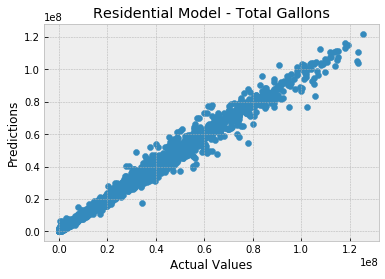

In [16]:
predictions = rf.predict(X)
plt.scatter(y, predictions)
plt.xlabel('Actual Values')
plt.ylabel('Predictions')
plt.title('Residential Model - Total Gallons')
# Set limits and labels
#ax.set_xlim([-10000, 140000])
# measurement for a period / run original data then build model between predicted value and actual / 
# make get residuals then make that my target 